In [2]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_error


import matplotlib.pyplot as plt
import numpy as np
import random
import glob

In [3]:
# Chemin vers les fichiers CSV
chemin = '../data/players/*.csv'

# Liste des noms de fichiers
fichiers = glob.glob(chemin)

# Initialisation d'une liste pour stocker les DataFrames de chaque fichier
dfs = []
# Liste des encodages à essayer
encodings_to_try = [ 'utf-8','ISO-8859-1']

# Charger et concaténer les fichiers
for fichier in fichiers:
    df = None
    # Essayer différents encodages jusqu'à ce que la lecture réussisse
    for encoding in encodings_to_try:
        try:
            df = pd.read_csv(fichier, encoding=encoding)
            print(f"Lecture réussie avec l'encodage {encoding}.")
            break  # Sortir de la boucle si la lecture réussit avec un encodage
        except UnicodeDecodeError:
            print(f"Échec de la lecture avec l'encodage {encoding}. Essayer un autre encodage.")

    if df is not None:
        # Ajouter une colonne 'source' pour identifier la provenance de chaque fichier
        nom_fichier = fichier.split('/')[-1]
        saison = nom_fichier.split('.')[0].split('-')
        df['source'] = f"{saison[0]}-{saison[1]}"
        # Concaténer 'first_name' et 'second_name' en une seule colonne 'name'
        df['name'] = df['first_name'] + ' ' + df['second_name']
        # Supprimer les colonnes 'first_name' et 'second_name'
        df = df.drop(columns=['first_name', 'second_name'])
        # Ajouter le DataFrame à la liste
        dfs.append(df)
    else:
        print("Échec de la lecture du fichier:", fichier)


# Concaténer tous les DataFrames en un seul
data = pd.concat(dfs, ignore_index=True)



# Maintenant vous pouvez faire du traitement de données sur le DataFrame 'data'
# Par exemple, afficher les premières lignes
print(data.info())


Échec de la lecture avec l'encodage utf-8. Essayer un autre encodage.
Lecture réussie avec l'encodage ISO-8859-1.
Lecture réussie avec l'encodage utf-8.
Lecture réussie avec l'encodage utf-8.
Lecture réussie avec l'encodage utf-8.
Lecture réussie avec l'encodage utf-8.
Lecture réussie avec l'encodage utf-8.
Lecture réussie avec l'encodage utf-8.
Lecture réussie avec l'encodage utf-8.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   goals_scored         5606 non-null   int64  
 1   assists              5606 non-null   int64  
 2   total_points         5606 non-null   int64  
 3   minutes              5606 non-null   int64  
 4   goals_conceded       5606 non-null   int64  
 5   creativity           5606 non-null   float64
 6   influence            5606 non-null   float64
 7   threat               5606 non-null   float64
 8   b

In [4]:
# Ingénierie des caractéristiques
selected_features = ['goals_scored','assists','goals_conceded','creativity','influence','threat','bonus','clean_sheets','red_cards','yellow_cards','now_cost']
X = data[selected_features]
y = data['total_points']

In [5]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Sélectionner uniquement les colonnes numériques
numeric_columns = X_train.select_dtypes(include=['number']).columns

In [7]:
# Vérification des valeurs manquantes dans les données d'entraînement
print("Valeurs manquantes dans y_train:", np.isnan(y_train).sum())

# Vérification des valeurs manquantes dans les données de test
print("Valeurs manquantes dans y_test:", np.isnan(y_test).sum())


Valeurs manquantes dans y_train: 0
Valeurs manquantes dans y_test: 0


In [8]:
# Définir les hyperparamètres à optimiser
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 4],
    'l2_regularization': [0.0, 0.1, 0.2]
}


In [9]:
# Create the HistGradientBoostingRegressor model
model = HistGradientBoostingRegressor()

In [10]:
# Train the model
model.fit(X_train, y_train)


HistGradientBoostingRegressor()

In [11]:
# Predict on the test set
y_pred = model.predict(X_test)

In [12]:
# Créer l'objet GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)


Evaluation des performances du modèle

In [13]:
# Effectuer la validation croisée
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')


In [14]:
# Exécuter la recherche par grille sur les données
grid_search.fit(X, y)

KeyboardInterrupt: 

In [15]:
# Calcul des métriques d'évaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
# Calculer la moyenne des scores de MSE
avg_mse = -scores.mean()

In [16]:
# Afficher les meilleurs paramètres et la meilleure MSE
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleure MSE:", -grid_search.best_score_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Mean Absolute Error:", mae)

# Afficher le score moyen de MSE
print("Moyenne des scores de MSE:", avg_mse)

Mean Squared Error: 33.03430553567649
R-squared: 0.9857973698022744
Mean Absolute Error: 3.469018531795853
Moyenne des scores de MSE: 38.69325786657404


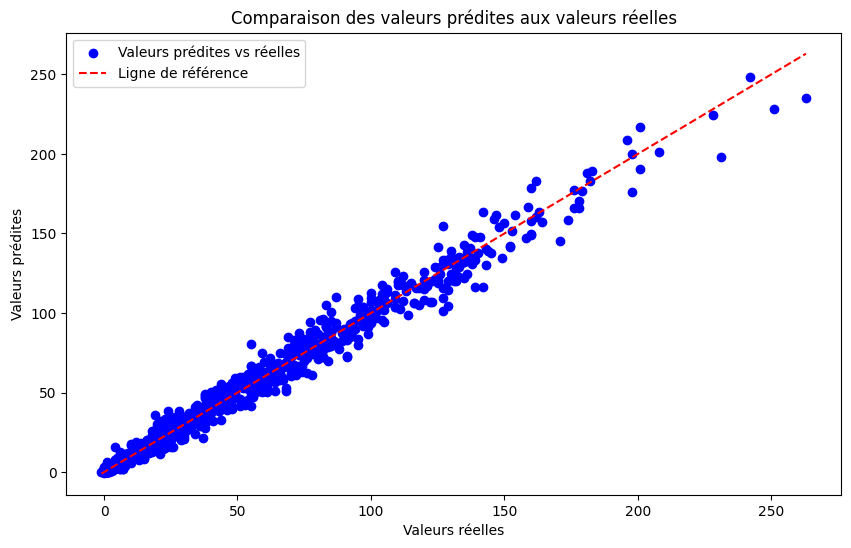

In [ ]:
# Tracer les valeurs réelles par rapport aux valeurs prédites
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Valeurs prédites vs réelles')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ligne de référence')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Comparaison des valeurs prédites aux valeurs réelles')
plt.legend()
plt.show()

In [17]:
# Créer un nouveau modèle avec les paramètres optimisés
optimal_model = HistGradientBoostingRegressor(
    l2_regularization=0.0,
    learning_rate=0.1,
    max_depth=5,
    max_iter=300,
    min_samples_leaf=2
)


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def plot_learning_curve_r2(estimator, X_train, y_train, X_test, y_test):
    train_r2 = []
    test_r2 = []

    for y_pred_train, y_pred_test in zip(estimator.staged_predict(X_train), estimator.staged_predict(X_test)):
        train_r2.append(r2_score(y_train, y_pred_train))
        test_r2.append(r2_score(y_test, y_pred_test))

    plt.plot(train_r2, label='Train R²')
    plt.plot(test_r2, label='Test R²')
    plt.xlabel('Number of Trees')
    plt.ylabel('R² Score')
    plt.title('Learning Curve (R²)')
    plt.legend()
    plt.show()

In [19]:
def plot_learning_curve_metrics(estimator, X_train, y_train, X_test, y_test):
    train_mse = []
    test_mse = []
    train_mae = []
    test_mae = []

    for y_pred_train, y_pred_test in zip(estimator.staged_predict(X_train), estimator.staged_predict(X_test)):
        train_mse.append(mean_squared_error(y_train, y_pred_train))
        test_mse.append(mean_squared_error(y_test, y_pred_test))
        train_mae.append(mean_absolute_error(y_train, y_pred_train))
        test_mae.append(mean_absolute_error(y_test, y_pred_test))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_mse, label='Train MSE')
    plt.plot(test_mse, label='Test MSE')
    plt.xlabel('Number of Trees')
    plt.ylabel('MSE')
    plt.title('Learning Curve (MSE)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_mae, label='Train MAE')
    plt.plot(test_mae, label='Test MAE')
    plt.xlabel('Number of Trees')
    plt.ylabel('MAE')
    plt.title('Learning Curve (MAE)')
    plt.legend()

    plt.tight_layout()
    plt.show()

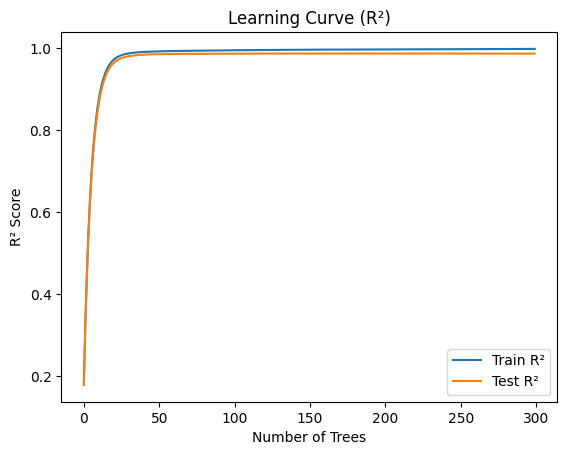

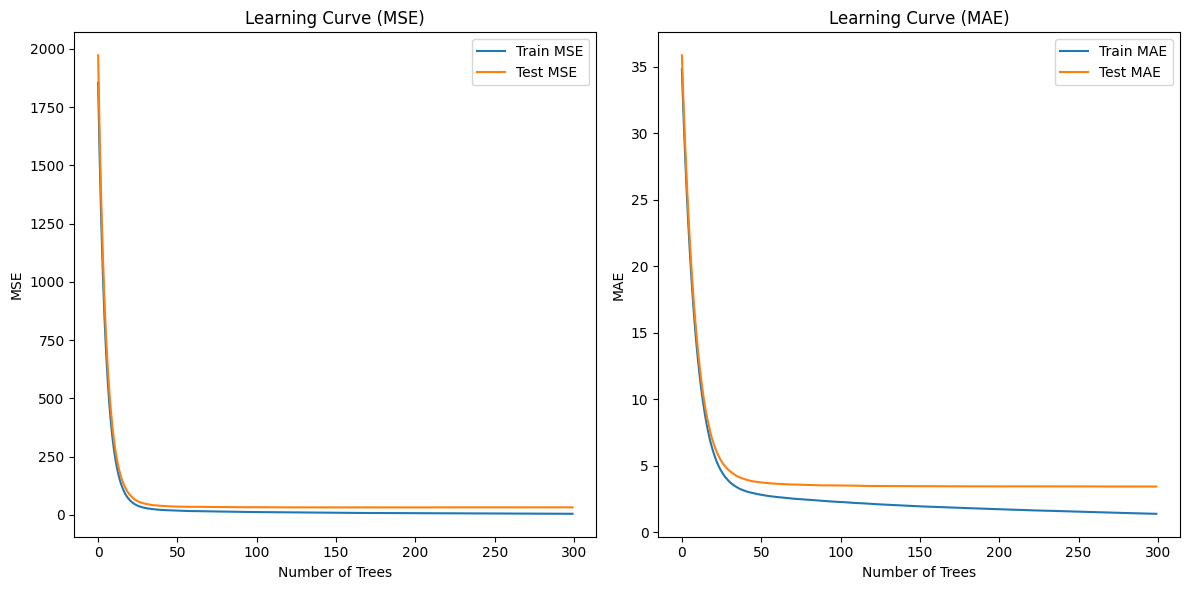

In [20]:
# Entraîner le nouveau modèle avec les données d'entraînement
optimal_model.fit(X_train, y_train)
plot_learning_curve_r2(optimal_model, X_train, y_train, X_test, y_test)
plot_learning_curve_metrics(optimal_model, X_train, y_train, X_test, y_test)


In [21]:
# Prédire sur les données de test
y_pred_optimal = optimal_model.predict(X_test)

In [22]:
# Calculer le RMSE
rmse_optimal = np.sqrt(mean_squared_error(y_test, y_pred_optimal))

# Calculer le MAPE
# Calculer le MAPE en évitant les divisions par zéro
mape_optimal = np.mean(np.abs((y_test - y_pred_optimal) / y_test.replace(0, np.nan))) * 100


In [23]:
# Évaluer les performances du nouveau modèle sur les données de test
mse_optimal = mean_squared_error(y_test, y_pred_optimal)
r2_optimal = r2_score(y_test, y_pred_optimal)
mae_optimal = mean_absolute_error(y_test, y_pred_optimal)

In [24]:

# Afficher les performances du nouveau modèle
print("Performances du modèle avec les paramètres optimisés :")
print("MSE:", mse_optimal)
print("R-squared:", r2_optimal)
print("MAE:", mae_optimal)
print("RMSE:", rmse_optimal)
print("MAPE:", mape_optimal)

Performances du modèle avec les paramètres optimisés :
MSE: 32.08169679182969
R-squared: 0.9866398000004664
MAE: 3.42548673150366
RMSE: 5.664070690928009
MAPE: 18.044422523730265


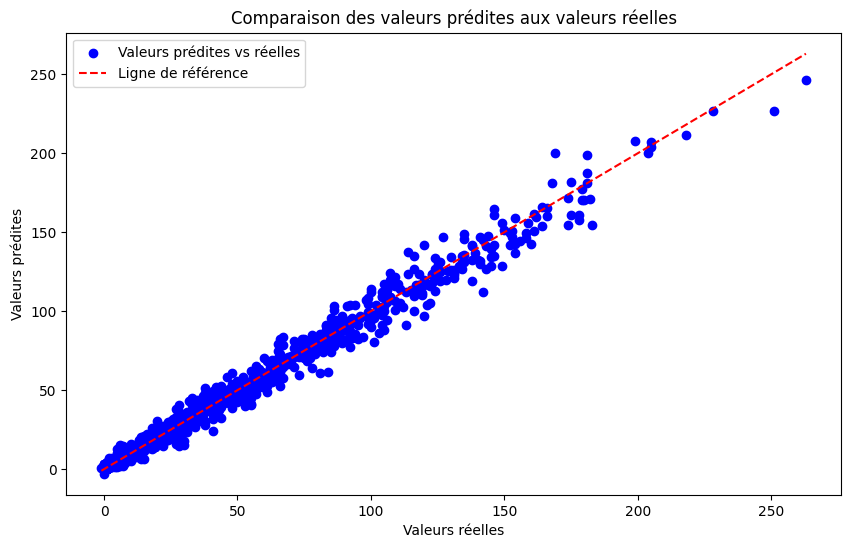

In [25]:
# Tracer les valeurs réelles par rapport aux valeurs prédites
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_optimal, color='blue', label='Valeurs prédites vs réelles')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ligne de référence')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Comparaison des valeurs prédites aux valeurs réelles')
plt.legend()
plt.show()

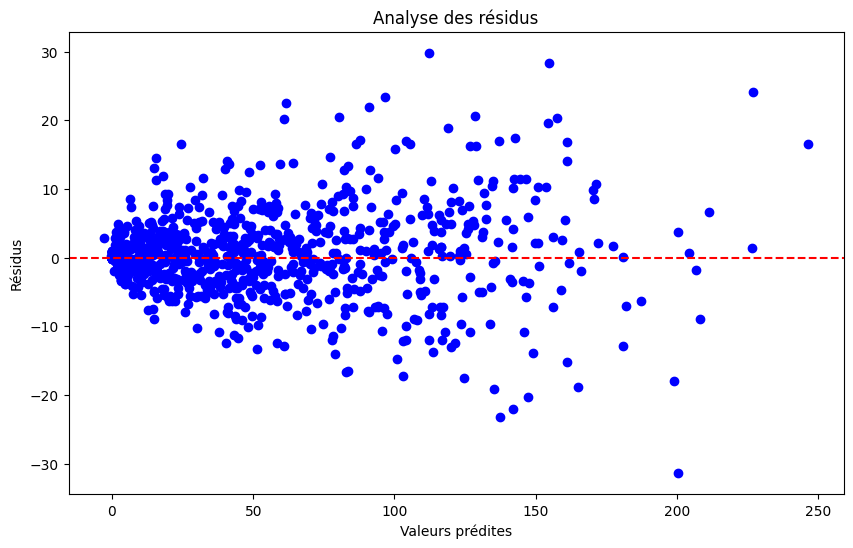

In [26]:
# Calculer les résidus
residuals = y_test - y_pred_optimal

# Tracer les résidus
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_optimal, residuals, color='blue')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.title('Analyse des résidus')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


les résidus sont distribués de manière aléatoire, cela indique que le modèle ne présente pas de biais systématique dans ses prédictions.

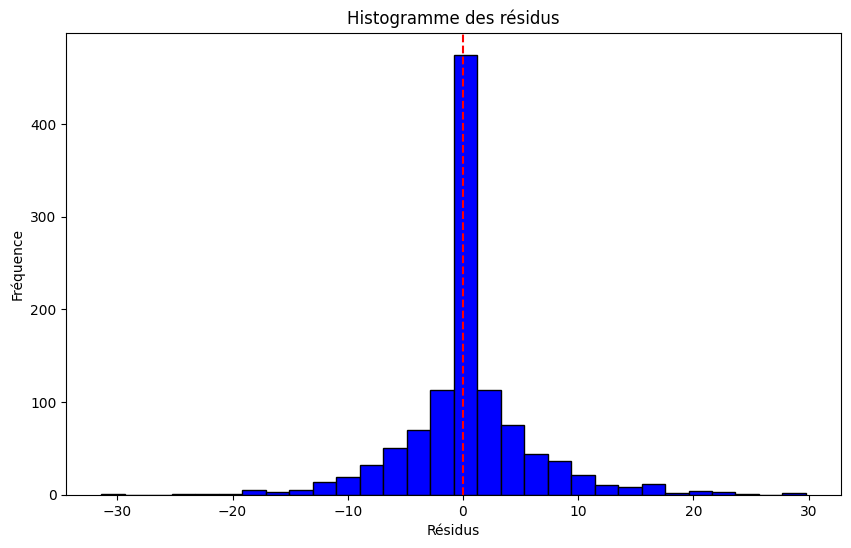

In [27]:
# Tracer l'histogramme des résidus
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='blue', edgecolor='black')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.title('Histogramme des résidus')
plt.axvline(x=0, color='red', linestyle='--')
plt.show()


In [ ]:
print(data.head())

In [65]:
def trouver_doublons(liste_elements):
    # Initialiser un dictionnaire pour compter les occurrences de chaque élément
    compteurs = {}
    
    # Parcourir chaque élément dans la liste
    for element in liste_elements:
        # Incrémenter le compteur pour cet élément dans le dictionnaire
        compteurs[element] = compteurs.get(element, 0) + 1
    
    # Initialiser une liste pour stocker les éléments qui apparaissent plusieurs fois
    doublons = []
    
    # Parcourir le dictionnaire pour trouver les éléments avec un compteur supérieur à 1
    for element, compte in compteurs.items():
        if compte > 1:
            doublons.append(element)
    
    # Retourner la liste des éléments qui apparaissent plusieurs fois
    return doublons
def calculer_moyennes_par_element(elements_doublons, df, selected_features):
    moyennes_par_element = {}  # Initialisation d'un dictionnaire pour stocker les moyennes par élément
    
    # Parcours de chaque élément
    for element in elements_doublons:
        # Sélection des lignes correspondant à l'élément actuel
        lignes_element = df[df['element'] == element]
        
        # Calcul de la moyenne des caractéristiques sélectionnées pour cet élément
        moyennes_element = lignes_element[selected_features].mean()
        
        # Stockage des moyennes dans le dictionnaire
        moyennes_par_element[element] = moyennes_element
    
    return moyennes_par_element

def mettre_a_jour_df_moyennes(df, moyennes_par_element):
    for element, moyennes in moyennes_par_element.items():
        # Récupérer l'index de la première ligne correspondant à l'élément
        index_ligne_element = df[df['element'] == element].index[0]
        
        # Mettre à jour les colonnes spécifiées avec les nouvelles valeurs moyennes
        for feature in selected_features:
            df.at[index_ligne_element, feature] = moyennes[feature]
    
    # Supprimer les lignes dupliquées
    df.drop_duplicates(subset='element', keep='first', inplace=True)
    
    return df


In [66]:
import pandas as pd
import boto3
import json

# Charger les informations d'identification à partir du fichier de configuration
with open('config.json') as f:
    config = json.load(f)

aws_access_key_id = config['AWS_ACCESS_KEY_ID']
aws_secret_access_key = config['AWS_SECRET_ACCESS_KEY']


#Créer une connexion S3 en utilisant les variables d'environnement
s3 = boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key)

# Nom du bucket S3
bucket_name = 'myfplbucket1'

# Préfixe du dossier dans S3 où se trouvent les fichiers gw
dossier_prefix = 'data/2023-24/gws/'

# Rechercher le fichier gw le plus récent
fichier_gw_recent = None
dernier_num_gw = 0

for num_gw in range(1, 39):
    nom_fichier_s3 = f'{dossier_prefix}gw{num_gw}.csv'
    try:
        s3.head_object(Bucket=bucket_name, Key=nom_fichier_s3)
        dernier_num_gw = num_gw
    except Exception as e:
        # Le fichier n'existe pas, passer au suivant
        pass
print(dernier_num_gw)
# Si aucun fichier gw n'a été trouvé, sortir
if dernier_num_gw == 0:
    print("Aucun fichier gw trouvé dans le dossier.")
    exit()

# Télécharger le fichier gw le plus récent
nom_fichier_s3_recent = f'{dossier_prefix}gw{dernier_num_gw}.csv'
chemin_local_recent = f'../data/2023-24/gws/gw{dernier_num_gw}.csv'
s3.download_file(bucket_name, nom_fichier_s3_recent, chemin_local_recent)

# Lire le fichier CSV avec pandas
team_data = pd.read_csv(chemin_local_recent)
team_data = team_data.rename(columns={'value': 'now_cost'})
selected_features = ['goals_scored','assists','goals_conceded','creativity','influence','threat','bonus','clean_sheets','red_cards','yellow_cards','now_cost']
liste_elements = team_data['element'].tolist()


elements_doublons = trouver_doublons(liste_elements)
moyennes_par_element = calculer_moyennes_par_element(elements_doublons, team_data, selected_features)
print("Les éléments qui apparaissent plusieurs fois dans la liste sont :", elements_doublons)
#print("Les moyennes par élément sont :", moyennes_par_element)
# Affichage des moyennes par élément


# Afficher les premières lignes du DataFrame pour vérifier si le fichier a été correctement lu
# Utilisation de la fonction pour mettre à jour le DataFrame
team_data = mettre_a_jour_df_moyennes(team_data, moyennes_par_element)

# Affichage du DataFrame mis à jour
team_data.head(20)

28
Les éléments qui apparaissent plusieurs fois dans la liste sont : [607, 335, 76, 86, 393, 705, 729, 72, 582, 21, 78, 798, 614, 79, 332, 682, 80, 314, 802, 619, 330, 337, 320, 64, 69, 328, 799, 89, 83, 811, 336, 319, 325, 734, 52, 673, 324, 804, 553, 327, 70, 648, 88, 331, 586, 665, 87, 602, 318, 75, 839, 66, 316, 595, 317, 63, 329, 81, 323, 68, 67, 77, 339, 575, 321, 333, 630, 643, 831, 326, 340, 82, 322, 74, 338, 84, 73, 315, 65, 71, 85, 644, 334, 62, 727, 631]
Les moyennes par élément sont : {607: goals_scored       0.0
assists            0.0
goals_conceded     0.0
creativity         0.0
influence          0.0
threat             0.0
bonus              0.0
clean_sheets       0.0
red_cards          0.0
yellow_cards       0.0
now_cost          43.0
dtype: float64, 335: goals_scored       0.0
assists            0.0
goals_conceded     0.0
creativity         0.0
influence          0.0
threat             0.0
bonus              0.0
clean_sheets       0.0
red_cards          0.0
yellow_card

C:\Users\victo\AppData\Local\Temp\ipykernel_17816\2436069926.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[index_ligne_element, feature] = moyennes[feature]
C:\Users\victo\AppData\Local\Temp\ipykernel_17816\2436069926.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[index_ligne_element, feature] = moyennes[feature]


,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,now_cost,was_home,yellow_cards
0,Femi Seriki,DEF,Sheffield Utd,0.0,0.0,0.0,0,0,0.0,653,...,2,2,0.0,0,-121,0,121,39,False,0.0
1,Josh Brooking,DEF,Chelsea,0.0,0.0,0.0,0,0,0.0,723,...,2,3,0.0,0,-29,47,76,40,True,0.0
2,Radek Vítek,GK,Man Utd,0.0,0.0,0.0,0,0,0.0,669,...,0,2,0.0,0,-45,0,45,40,True,0.0
3,Jack Hinshelwood,MID,Brighton,0.0,0.0,0.0,0,0,0.0,621,...,0,1,0.0,0,-1104,12,1116,45,True,0.0
4,Jadon Sancho,MID,Man Utd,0.0,0.0,0.0,0,0,0.0,397,...,0,2,0.0,0,-81,0,81,67,True,0.0
5,Divock Origi,FWD,Nott'm Forest,2.2,0.0,0.0,0,0,0.6,714,...,0,1,23.0,2,1114,2000,886,50,False,0.0
6,Sam Curtis,DEF,Sheffield Utd,-0.5,0.0,0.0,0,0,0.0,828,...,2,2,0.0,0,43,64,21,40,False,0.0
7,Rhys Norrington-Davies,DEF,Sheffield Utd,0.0,0.0,0.0,0,0,0.0,487,...,2,2,0.0,0,-415,90,505,39,False,0.0
8,Vitaly Janelt,MID,Brentford,0.6,0.0,0.0,6,0,25.6,105,...,1,2,4.0,2,-474,93,567,53,False,0.0
9,Ionuț Radu,GK,Bournemouth,1.0,0.0,0.0,0,0,0.0,607,...,2,2,0.0,0,74,295,221,43,True,0.0


In [72]:
team_data.head(20)
#export
team_data.to_csv('../../team_data.csv', index=False)

In [70]:
def predict_player_performance(model, player_name, data):
    # Filtrer les données pour obtenir les caractéristiques du joueur spécifié
    player_data = data[data['name'] == player_name]

    # Sélectionner uniquement les caractéristiques utilisées lors de l'entraînement
    selected_features = ['goals_scored','assists','goals_conceded','creativity','influence','threat','bonus','clean_sheets','red_cards','yellow_cards','now_cost']

    player_data = player_data[selected_features]

    # Effectuer la prédiction
    predicted_performance = optimal_model.predict(player_data)

    # Calculer la moyenne des performances prédites
    average_performance = np.mean(predicted_performance)

    return average_performance

In [71]:
# Nom du joueur à prédire
player_name = 'Erling Haaland'

# Prédiction des performances du joueur
predicted_performance = predict_player_performance(optimal_model, player_name, team_data)

print("Performances prédites (total_points) pour le joueur: ",player_name, predicted_performance)


Performances prédites (total_points) pour le joueur:  Erling Haaland 1.5106814914103146


In [73]:
# Sélectionner les informations pour le joueur spécifié
player_info = team_data[team_data['name'] == player_name]

# Vérifier si le joueur spécifié est présent dans les données
if not player_info.empty:
    # Extraire les informations nécessaires
    now_cost = player_info['now_cost'].values[0]
    total_points = player_info['total_points'].values[0]
    position = player_info['position'].values[0]  # Assurez-vous que 'element_type' contient les informations sur le poste du joueur

    # Afficher les informations
    print("Nom du joueur:", player_name)
    print("Prix actuel:", now_cost)
    print("Total de points actuel:", total_points)
    print("Poste:", position)
else:
    print("Le joueur spécifié n'a pas été trouvé dans les données.")


Nom du joueur: Erling Haaland
Prix actuel: 144
Total de points actuel: 2
Poste: FWD


prediction pour les joueurs de la saison en cours

In [74]:

# Créer une liste pour stocker les prédictions de performances pour tous les joueurs de la saison 23-24
all_predictions = []

# Itérer sur chaque joueur dans le DataFrame de la saison 23-24
for player_name in team_data['name']:
    # Prédiction des performances du joueur avec le modèle entraîné
    predicted_performance = predict_player_performance(optimal_model, player_name, team_data)

    # Ajouter le nom du joueur et ses prédictions à la liste
    all_predictions.append((player_name, predicted_performance))

# Afficher les prédictions pour tous les joueurs de la saison 23-24
for player_name, predicted_performance in all_predictions:
    print("Performances prédites (total_points) pour le joueur:", player_name, ":", predicted_performance)


Performances prédites (total_points) pour le joueur: Femi Seriki : -0.0014716258871915135
Performances prédites (total_points) pour le joueur: Josh Brooking : -0.0014716258871915135
Performances prédites (total_points) pour le joueur: Radek Vítek : -0.0014716258871915135
Performances prédites (total_points) pour le joueur: Jack Hinshelwood : 0.11782710047203429
Performances prédites (total_points) pour le joueur: Jadon Sancho : -0.0635932732495356
Performances prédites (total_points) pour le joueur: Divock Origi : 2.3419897224299304
Performances prédites (total_points) pour le joueur: Sam Curtis : -0.0014716258871915135
Performances prédites (total_points) pour le joueur: Rhys Norrington-Davies : -0.0014716258871915135
Performances prédites (total_points) pour le joueur: Vitaly Janelt : 3.6997615373825825
Performances prédites (total_points) pour le joueur: Ionuț Radu : 0.11782710047203429
Performances prédites (total_points) pour le joueur: Andre Brooks : 0.11782710047203429
Performan

In [34]:
print(len(all_predictions))

924


In [35]:
# Créer un dictionnaire à partir de la liste de toutes les prédictions
predicted_performances_dict = {player_name: predicted_performance for player_name, predicted_performance in all_predictions}


In [75]:
team_data['predicted_performance'] = team_data['name'].map(predicted_performances_dict)

print(team_data.head())
team_data.to_csv("../data/last_gw_players.csv", index=False)

               name position           team   xP  assists  bonus  bps  \
0       Femi Seriki      DEF  Sheffield Utd  0.0      0.0    0.0    0   
1     Josh Brooking      DEF        Chelsea  0.0      0.0    0.0    0   
2       Radek Vítek       GK        Man Utd  0.0      0.0    0.0    0   
3  Jack Hinshelwood      MID       Brighton  0.0      0.0    0.0    0   
4      Jadon Sancho      MID        Man Utd  0.0      0.0    0.0    0   

   clean_sheets  creativity  element  ...  team_h_score  threat  total_points  \
0             0         0.0      653  ...             2     0.0             0   
1             0         0.0      723  ...             3     0.0             0   
2             0         0.0      669  ...             2     0.0             0   
3             0         0.0      621  ...             1     0.0             0   
4             0         0.0      397  ...             2     0.0             0   

   transfers_balance  transfers_in  transfers_out  now_cost  was_home  \
0

Création d'une equipe

In [37]:
def create_team(predicted_performances, data, budget=100, max_players_per_team=3):
    team = []
    remaining_budget = budget
    positions_quota = {'GK': 2, 'DEF': 5, 'MID': 5, 'FWD': 3}
    positions_count = {'GK': 0, 'DEF': 0, 'MID': 0, 'FWD': 0}
    team_players_count = {}

    # Tri des joueurs prédits par performances décroissantes
    sorted_players = sorted(predicted_performances.items(), key=lambda x: x[1], reverse=True)

    # Sélection des joueurs pour l'équipe en respectant les contraintes
    for player_name, predicted_performance in sorted_players:
        # Vérifier si l'équipe a déjà atteint le nombre maximum de joueurs
        if len(team) >= 15:
            break

        # Vérifier si le joueur est présent dans les données
        player_data = data[data['name'] == player_name]
        if not player_data.empty:
            player_cost = player_data['now_cost'].values[0]
            player_position = player_data['position'].values[0]
            player_team = player_data['team'].values[0]

            # Vérification des contraintes de budget, de nombre maximum de joueurs par équipe et de quota par poste
            if player_cost <= remaining_budget and team_players_count.get(player_team, 0) < max_players_per_team and positions_count[player_position] < positions_quota[player_position]:
                team.append({
                    'name': player_name,
                    'position': player_position,
                    'team': player_team,
                    'cost': player_cost,
                    'predicted_performance': predicted_performance
                })
                remaining_budget -= player_cost
                positions_count[player_position] += 1
                team_players_count[player_team] = team_players_count.get(player_team, 0) + 1

    return team


In [38]:
# Créer une équipe en utilisant les performances prédites
team = create_team(predicted_performances_dict, team_data, budget=1000, max_players_per_team=3)
team

[{'name': 'Bruno Borges Fernandes',
  'position': 'MID',
  'team': 'Man Utd',
  'cost': 82,
  'predicted_performance': 17.924592939005333},
 {'name': 'Son Heung-min',
  'position': 'MID',
  'team': 'Spurs',
  'cost': 98,
  'predicted_performance': 16.983516659118173},
 {'name': 'Alex Iwobi',
  'position': 'MID',
  'team': 'Fulham',
  'cost': 53,
  'predicted_performance': 16.71066074813183},
 {'name': 'Jean-Philippe Mateta',
  'position': 'FWD',
  'team': 'Crystal Palace',
  'cost': 49,
  'predicted_performance': 14.514828594906392},
 {'name': 'Cole Palmer',
  'position': 'MID',
  'team': 'Chelsea',
  'cost': 57,
  'predicted_performance': 12.803993661925578},
 {'name': 'Gustavo Hamer',
  'position': 'MID',
  'team': 'Sheffield Utd',
  'cost': 49,
  'predicted_performance': 12.476586657390078},
 {'name': 'André Onana',
  'position': 'GK',
  'team': 'Man Utd',
  'cost': 48,
  'predicted_performance': 12.314858075582213},
 {'name': 'Antoine Semenyo',
  'position': 'FWD',
  'team': 'Bourn

In [ ]:
# Afficher l'équipe sélectionnée
print("Équipe sélectionnée:")
for player in team:
    print(f"Nom: {player['name']}, Poste: {player['position']}, Équipe: {player['team']}, Coût: {player['cost']}, Performance Prédite: {player['predicted_performance']}")


Équipe sélectionnée:
Nom: Kai Havertz, Poste: MID, Équipe: Arsenal, Coût: 71, Performance Prédite: 19.310514668537042
Nom: Phil Foden, Poste: MID, Équipe: Man City, Coût: 81, Performance Prédite: 19.248851617795275
Nom: Rodrigo Muniz Carvalho, Poste: FWD, Équipe: Fulham, Coût: 45, Performance Prédite: 16.305604342547653
Nom: Harry Wilson, Poste: MID, Équipe: Fulham, Coût: 53, Performance Prédite: 16.221667231488183
Nom: Timo Werner, Poste: FWD, Équipe: Spurs, Coût: 63, Performance Prédite: 15.942504463894986
Nom: Martin Ødegaard, Poste: MID, Équipe: Arsenal, Coût: 85, Performance Prédite: 15.890662428901994
Nom: Edson Álvarez Velázquez, Poste: MID, Équipe: West Ham, Coût: 50, Performance Prédite: 15.73184482872646
Nom: Ollie Watkins, Poste: FWD, Équipe: Aston Villa, Coût: 89, Performance Prédite: 15.271087737945109
Nom: Mads Roerslev Rasmussen, Poste: DEF, Équipe: Brentford, Coût: 44, Performance Prédite: 14.026874342855244
Nom: Benjamin White, Poste: DEF, Équipe: Arsenal, Coût: 56, Pe

In [39]:
# Calcul du prix total de l'équipe recommandée
total_cost = sum(player['cost'] for player in team)
total_team_points = sum(player['predicted_performance'] for player in team)
print("Le cout total de l'equipe est de:", total_cost, "k£")
print("Le nombre de point total de l'equipe est de:", total_team_points)

Le cout total de l'equipe est de: 824 k£
Le nombre de point total de l'equipe est de: 185.9789642604482


In [40]:

# Affichage de la composition de l'équipe recommandée
print("Composition de l'équipe recommandée:")
for player in team:
    print("Joueur:", player['name'])
    print("Poste:", player['position'])
    print("Équipe:", player['team'])
    print("Prix:", player['cost'], 'k£')
    print("Score prédit:", player['predicted_performance'])
    print()

Composition de l'équipe recommandée:
Joueur: Bruno Borges Fernandes
Poste: MID
Équipe: Man Utd
Prix: 82 k£
Score prédit: 17.924592939005333

Joueur: Son Heung-min
Poste: MID
Équipe: Spurs
Prix: 98 k£
Score prédit: 16.983516659118173

Joueur: Alex Iwobi
Poste: MID
Équipe: Fulham
Prix: 53 k£
Score prédit: 16.71066074813183

Joueur: Jean-Philippe Mateta
Poste: FWD
Équipe: Crystal Palace
Prix: 49 k£
Score prédit: 14.514828594906392

Joueur: Cole Palmer
Poste: MID
Équipe: Chelsea
Prix: 57 k£
Score prédit: 12.803993661925578

Joueur: Gustavo Hamer
Poste: MID
Équipe: Sheffield Utd
Prix: 49 k£
Score prédit: 12.476586657390078

Joueur: André Onana
Poste: GK
Équipe: Man Utd
Prix: 48 k£
Score prédit: 12.314858075582213

Joueur: Antoine Semenyo
Poste: FWD
Équipe: Bournemouth
Prix: 45 k£
Score prédit: 12.065359305665883

Joueur: David Datro Fofana
Poste: FWD
Équipe: Burnley
Prix: 50 k£
Score prédit: 11.870858975701719

Joueur: Bart Verbruggen
Poste: GK
Équipe: Brighton
Prix: 44 k£
Score prédit: 11.

In [ ]:
print('Performances prédites (total_points) pour le joueur:  Erling Haaland 6.480142567968518')
print('Nom du joueur: Erling Haaland')
print('Prix actuel: 145')
print('Total de points actuel: 6')
print('Poste: FWD')

Performances prédites (total_points) pour le joueur:  Erling Haaland 6.480142567968518
Nom du joueur: Erling Haaland
Prix actuel: 145
Total de points actuel: 6
Poste: FWD


In [41]:
def get_top_players_by_position(team_data, position):
    # Filtrer les données pour la position spécifiée
    position_data = team_data[team_data['position'] == position]
    
    # Trier les données en fonction de la valeur prédite dans l'ordre décroissant
    sorted_position_data = position_data.sort_values(by='predicted_performance', ascending=False)
    
    # Sélectionner les trois premiers joueurs
    top_players = sorted_position_data.head(10)
    
    return top_players


In [47]:
# Obtenez les trois meilleurs joueurs pour la position DEF
top_defenders = get_top_players_by_position(team_data, 'DEF')
#print("Les trois meilleurs défenseurs :\n", top_defenders)

# Obtenez les trois meilleurs joueurs pour la position FWD
top_forwards = get_top_players_by_position(team_data, 'FWD')
#print("Les trois meilleurs attaquants :\n", top_forwards)

# Obtenez les trois meilleurs joueurs pour la position GK
top_goalkeepers = get_top_players_by_position(team_data, 'GK')
#print("Les trois meilleurs gardiens de but :\n", top_goalkeepers)

# Obtenez les trois meilleurs joueurs pour la position MID
top_midfielders = get_top_players_by_position(team_data, 'MID')
#print("Les trois meilleurs milieux de terrain :\n", top_midfielders)
# Concaténer les DataFrames pour chaque position en un seul DataFrame reinitilaize index
top_players = pd.concat([top_defenders, top_forwards, top_goalkeepers, top_midfielders], ignore_index=True)
top_players.reset_index(drop=True, inplace=True)
top_players

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,now_cost,was_home,yellow_cards,predicted_performance
0,Benjamin White,DEF,Arsenal,9.0,2,3,37,0,47.0,29,...,2,4.0,11,104603,116062,11459,56,True,0,11.134718
1,John Stones,DEF,Man City,5.1,0,2,27,0,4.5,368,...,1,33.0,10,1115,5255,4140,53,False,0,9.962567
2,Rayan Aït-Nouri,DEF,Wolves,6.0,0,2,26,0,14.1,545,...,2,44.0,10,2541,12430,9889,45,True,0,9.259052
3,Cristian Romero,DEF,Spurs,6.3,0,2,35,1,1.0,511,...,0,0.0,8,117246,127787,10541,50,False,0,8.313573
4,Victor Lindelöf,DEF,Man Utd,2.2,0,1,29,1,2.3,386,...,2,42.0,7,2375,3076,701,45,True,0,8.294405
5,Jayden Bogle,DEF,Sheffield Utd,1.3,1,0,25,1,0.1,476,...,2,34.0,9,608,1053,445,45,False,0,8.082759
6,Pedro Porro,DEF,Spurs,2.3,0,1,30,1,34.4,506,...,0,0.0,7,-93520,45303,138823,57,False,0,8.037486
7,Diogo Dalot Teixeira,DEF,Man Utd,2.5,0,0,28,1,6.2,377,...,2,13.0,6,27759,51326,23567,52,True,0,8.029747
8,Jack Robinson,DEF,Sheffield Utd,1.0,0,0,28,0,10.3,576,...,2,33.0,7,118,300,182,43,False,0,7.710891
9,Lewis Dunk,DEF,Brighton,7.2,0,1,27,1,0.7,129,...,1,7.0,7,16046,50926,34880,52,True,0,7.599738


In [ ]:
#Exporter top_players en csv
top_players.to_csv('../data/2023-24/top_players.csv', index=False)